In [1]:
import pandas
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

Using TensorFlow backend.


In [2]:
input_shape = (224, 224)
categories_num = 37
batch_size = 32

In [3]:
train_data = pandas.read_csv('../train_pets.csv', usecols=['Category', 'Path'])
val_data = pandas.read_csv('../val_pets.csv', usecols=['Category', 'Path'])

train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=10,
        zoom_range=0.1,
        brightness_range=(0.7, 1.3),
        horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='.',
        x_col='Path',
        y_col='Category',
        class_mode='categorical',
        target_size=input_shape,
        interpolation='bicubic',
        batch_size=batch_size)

val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='.',
        x_col='Path',
        y_col='Category',
        class_mode='categorical',
        target_size=input_shape,
        interpolation='bicubic',
        batch_size=batch_size)

Found 6434 validated image filenames belonging to 37 classes.
Found 333 validated image filenames belonging to 37 classes.


In [4]:
def plot_history(histories, save=False, folder=""):
    # Plot training & validation accuracy values
    plt.figure(1)
    for i in range(len(histories)):
        plt.plot(histories[i].history['categorical_accuracy'])
        plt.plot(histories[i].history['val_categorical_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
#         plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.figure(2)
    for i in range(len(histories)):
        plt.plot(histories[i].history['loss'])
        plt.plot(histories[i].history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
#         plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()

In [5]:
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.layers import *
from keras.metrics import categorical_accuracy
from keras.optimizers import Adam

def get_model(weights, trainable):
    resnet = ResNet50(weights=weights, include_top=False)

    x = resnet.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.7)(x)
#     x = Dense(256, activation='relu')(x)
#     x = Dropout(0.5)(x)
    predictions = Dense(categories_num, activation='softmax')(x)

    model = Model(inputs=resnet.input, outputs=predictions)

    for layer in resnet.layers:
        layer.trainable = trainable

    model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=[categorical_accuracy])
#     model.summary()
    
    return model

### Первый тип переноса обучения

Берем предобученную сеть **ResNet-50**, заменяем последние слои для классификации на свои для последующего обучения. Всем слоям из **ResNet** ставим флаг *trainable=False*.

W1215 19:10:01.073765 140097025677120 module_wrapper.py:139] From /home/mikhailm/anaconda3/envs/reinf_learn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1215 19:10:01.076408 140097025677120 module_wrapper.py:139] From /home/mikhailm/anaconda3/envs/reinf_learn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1215 19:10:01.082606 140097025677120 module_wrapper.py:139] From /home/mikhailm/anaconda3/envs/reinf_learn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W1215 19:10:01.106819 140097025677120 module_wrapper.py:139] From /home/mikhailm/anaconda3/envs/reinf_learn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_de

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

W1215 19:10:10.600617 140097025677120 module_wrapper.py:139] From /home/mikhailm/anaconda3/envs/reinf_learn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/10
201/201 [==============================] - 152s 758ms/step - loss: 4.3454 - categorical_accuracy: 0.0501 - val_loss: 4.0479 - val_categorical_accuracy: 0.0344
Epoch 2/10
201/201 [==============================] - 148s 736ms/step - loss: 3.4881 - categorical_accuracy: 0.1205 - val_loss: 4.0541 - val_categorical_accuracy: 0.0365
Epoch 3/10
201/201 [==============================] - 140s 694ms/step - loss: 2.9356 - categorical_accuracy: 0.2119 - val_loss: 4.0695 - val_categorical_accuracy: 0.0199
Epoch 4/10
201/201 [==============================] - 155s 772ms/step - loss: 2.4966 - categorical_accuracy: 0.2974 - val_loss: 4.0661 - val_categorical_accuracy: 0.0233
Epoch 5/10
201/201 [==============================] - 154s 765ms/step - loss: 2.2481 - categorical_accuracy: 0.3607 - val_loss: 4.0064 - val_categorical_accuracy: 0.0266
Epoch 6/10
201/201 [==============================] - 151s 749ms/step - loss: 2.0091 - categorical_accuracy: 0.4125 - val_loss: 4.1263 - val_categoric

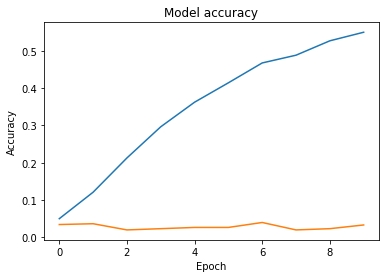

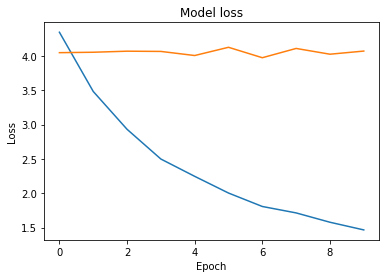

In [6]:
model = get_model(weights='imagenet', trainable=False)

history_1 = model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=10,
            verbose=1,
            callbacks=[EarlyStopping(patience=4)])

plot_history([history_1])

### Второй тип переноса обучения

Берем предобученную сеть **ResNet-50**, заменяем последние слои для классификации на свои. Всем слоям из **ResNet** ставим флаг *trainable=True*, для их дообучения под нашу задачу.

W1215 18:22:09.949770 139942488381248 module_wrapper.py:139] From /home/mikhailm/anaconda3/envs/reinf_learn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1215 18:22:09.952522 139942488381248 module_wrapper.py:139] From /home/mikhailm/anaconda3/envs/reinf_learn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1215 18:22:09.960235 139942488381248 module_wrapper.py:139] From /home/mikhailm/anaconda3/envs/reinf_learn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W1215 18:22:09.989477 139942488381248 module_wrapper.py:139] From /home/mikhailm/anaconda3/envs/reinf_learn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_de

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

W1215 18:22:26.999787 139942488381248 deprecation.py:323] From /home/mikhailm/anaconda3/envs/reinf_learn/lib/python3.7/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1215 18:22:28.905169 139942488381248 module_wrapper.py:139] From /home/mikhailm/anaconda3/envs/reinf_learn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W1215 18:22:30.862569 139942488381248 module_wrapper.py:139] From /home/mikhailm/anaconda3/envs/reinf_learn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/10
201/201 [==============================] - 136s 679ms/step - loss: 2.0255 - categorical_accuracy: 0.4562 - val_loss: 0.8819 - val_categorical_accuracy: 0.7438
Epoch 2/10
201/201 [==============================] - 119s 592ms/step - loss: 0.7285 - categorical_accuracy: 0.7841 - val_loss: 0.6940 - val_categorical_accuracy: 0.7807
Epoch 3/10
201/201 [==============================] - 119s 592ms/step - loss: 0.4714 - categorical_accuracy: 0.8599 - val_loss: 0.5557 - val_categorical_accuracy: 0.8306
Epoch 4/10
201/201 [==============================] - 119s 593ms/step - loss: 0.3443 - categorical_accuracy: 0.8940 - val_loss: 0.6668 - val_categorical_accuracy: 0.8140
Epoch 5/10
201/201 [==============================] - 120s 598ms/step - loss: 0.2616 - categorical_accuracy: 0.9145 - val_loss: 0.6438 - val_categorical_accuracy: 0.8206
Epoch 6/10
201/201 [==============================] - 121s 602ms/step - loss: 0.2598 - categorical_accuracy: 0.9206 - val_loss: 0.7288 - val_categoric

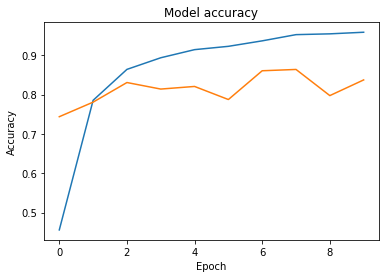

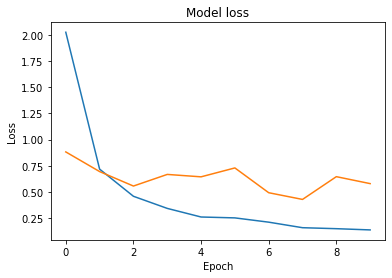

In [6]:
model = get_model(weights='imagenet', trainable=True)

history_3 = model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=10,
            verbose=1,
            callbacks=[EarlyStopping(patience=4)])

plot_history([history_3])

/home/mikhailm/anaconda3/envs/reinf_learn/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Epoch 1/10
201/201 [==============================] - 148s 734ms/step - loss: 1.4165 - categorical_accuracy: 0.5928 - val_loss: 1.8397 - val_categorical_accuracy: 0.4850
Epoch 2/10
201/201 [==============================] - 122s 606ms/step - loss: 0.7339 - categorical_accuracy: 0.7735 - val_loss: 1.2206 - val_categorical_accuracy: 0.6777
Epoch 3/10
201/201 [==============================] - 123s 613ms/step - loss: 0.5480 - categorical_accuracy: 0.8321 - val_loss: 1.5080 - val_categorical_accuracy: 0.6478
Epoch 4/10
201/201 [==============================] - 121s 601ms/step - loss: 0.4390 - categorical_accuracy: 0.8635 - val_loss: 1.3764 - val_categorical_accuracy: 0.6744
Epoch 5/10
201/201 [==============================] - 122s 608ms/step - loss: 0.3815 - categorical_accuracy: 0.8815 - val_loss: 1.3215 - val_categorical_accuracy: 0.6578
Epoch 6/10
201/201 [==============================] - 121s 604ms/step - loss: 0.3568 - categorical_accuracy: 0.8884 - val_loss: 1.0000 - val_categoric

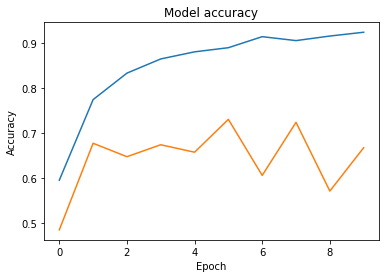

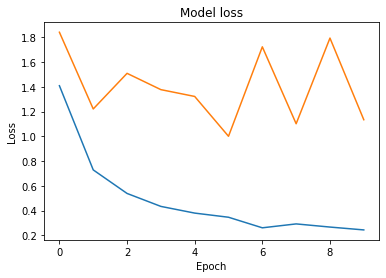

In [15]:
# x = resnet.output
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x)
# predictions = Dense(categories_num, activation='softmax')(x)

model = get_model(weights='imagenet', trainable=True)

history_2 = model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=10,
            verbose=1,
            callbacks=[EarlyStopping(patience=4)])

plot_history([history_2])

### Третий тип переноса обучения

Берем необученную сеть **ResNet-50**, заменяем последние слои для классификации на свои. Пытаемся обучить полученную архитектуру с нуля.

W1215 19:38:20.309634 140097025677120 nn_ops.py:4283] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

Epoch 1/100
201/201 [==============================] - 152s 755ms/step - loss: 4.9022 - categorical_accuracy: 0.0317 - val_loss: 5.5468 - val_categorical_accuracy: 0.0332
Epoch 2/100
201/201 [==============================] - 154s 768ms/step - loss: 4.1413 - categorical_accuracy: 0.0353 - val_loss: 4.0230 - val_categorical_accuracy: 0.0375
Epoch 3/100
201/201 [==============================] - 154s 767ms/step - loss: 4.0398 - categorical_accuracy: 0.0477 - val_loss: 4.9526 - val_categorical_accuracy: 0.0532
Epoch 4/100
201/201 [==============================] - 150s 748ms/step - loss: 3.9188 - categorical_accuracy: 0.0586 - val_loss: 4.4101 - val_categorical_accuracy: 0.0731
Epoch 5/100
201/201 [==============================] - 151s 750ms/step - loss: 3.8428 - categorical_accuracy: 0.0673 - val_loss: 4.0977 - val_categorical_accuracy: 0.0432
Epoch 6/100
201/201 [==============================] - 153s 761ms/step - loss: 3.7870 - categorical_accuracy: 0.0802 - val_loss: 3.4598 - val_cat

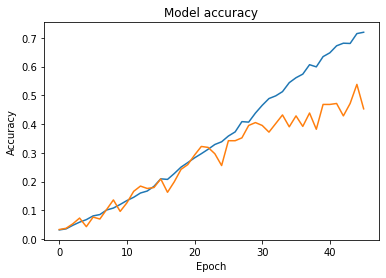

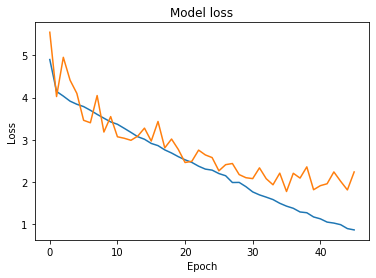

In [7]:
model = get_model(weights=None, trainable=True)

history_3 = model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=100,
            verbose=1,
            callbacks=[EarlyStopping(patience=10)])

plot_history([history_3])

In [7]:
model.save('resnet-pool-drop07.h5')

### Тестирование

In [8]:
best_model = load_model('resnet-pool-drop07.h5')

W1215 21:29:28.790705 140097025677120 nn_ops.py:4283] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [13]:
test_data = pandas.read_csv('../test_pets.csv', usecols=['Category', 'Path'])
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='.',
        x_col='Path',
        y_col='Category',
        class_mode='categorical',
        target_size=input_shape,
        interpolation='bicubic',
        batch_size=batch_size)

Found 333 validated image filenames belonging to 37 classes.


In [14]:
history = best_model.evaluate_generator(
        test_generator,
        steps=test_generator.n // batch_size,
        verbose=1)

print(f'Test loss: {history[0]}, Test accuracy: {history[1]}')

10/10 [==============================] - 1s 146ms/step
Test loss: 0.6234709247946739, Test accuracy: 0.825


Original: american_bulldog
american_bulldog 0.9998702
Sphynx 0.0001059191
pug 9.982098e-06


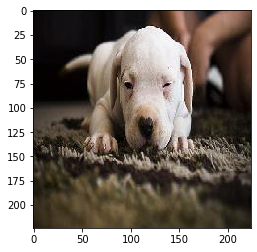

In [123]:
sample = test_generator.next()
image_array = sample[0]
categories_dict = {value: key for key, value in test_generator.class_indices.items()}
category = categories_dict[np.argmax(sample[1][0])]

predictions = best_model.predict(image_array)[0]

best_args = np.argsort(predictions)[::-1][:3]

print(f'Original: {category}')
for i in best_args:
    print(categories_dict[i], predictions[i])

plt.imshow(image_array[0])